### **Tutorial:Mouse Brain**

This experiment applies SpatialModal to mouse brain Sagittal Anterior, Sagittal Posterior, and Coronal slices, utilizing joint training for the sagittal sections to capture shared biological patterns. While this notebook specifically demonstrates the Coronal slice workflow, we also present the results of joint training to illustrate the framework's superior performance in integrating multiple tissue sections for enhanced spatial domain identification and gene reconstruction.

#### **Loading package**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from Spatialmodal.spatialmodal import SpatialModal
from Spatialmodal.reconstruction import RF
from Spatialmodal.data_process import load_ST_file
from Spatialmodal.utils import mclust_R
from sklearn.decomposition import PCA
import scanpy as sc
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#### **Coronal slices**

In [4]:
sample = 'mouse_brain_coronal'
fold = f"../Data/mouse_brain/{sample}"
fold = "/home/zhaodongmin/SpatialModal/data/mouse_brain/mouse_brain_coronal"
adata = load_ST_file(fold)
n_clusters = 30

In [5]:
model = SpatialModal(adata, device=device, epochs=1000, fold=fold, image_use=True, if_img=True)
adata = model.train()

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extracting features: 100%|██████████ [ time left: 00:00 ]
Training SpatialModal: 100%|██████████ [ time left: 00:00 ]


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


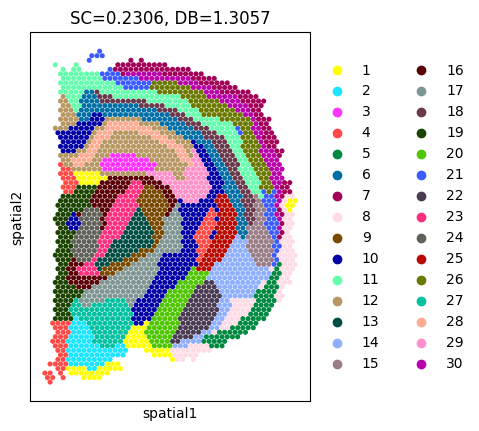

In [6]:
pca = PCA(n_components=20, random_state=42)
embedding = pca.fit_transform(adata.obsm['emb'].copy())
adata.obsm['emb_pca'] = embedding

mclust_R(adata, n_clusters, use_rep='emb_pca', key_added='domain')

SC = silhouette_score(adata.obsm['emb_pca'], adata.obs['domain'])
DB = davies_bouldin_score(adata.obsm['emb_pca'], adata.obs['domain'])

sc.pl.spatial(adata, color='domain', show=True, img_key=None, size=1.5, title=f"SC={SC:.4f}, DB={DB:.4f}")


#### **Joint training**

In this experiment, image features were first extracted individually from the sagittal anterior and posterior brain slices and subsequently concatenated to form a joint feature distribution. In this demonstration, we utilize a pre-processed .h5ad file composed of these combined sagittal datasets. For detailed information regarding the data construction process, please refer to the Methods section of the manuscript.

In [7]:
adata = sc.read_h5ad("/home/zhaodongmin/task_spa/data/mouse_brain_a_p/mouse_anterior_posterior_brain_merged.h5ad")

adata

AnnData object with n_obs × n_vars = 6050 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    obsm: 'image_representation', 'spatial'

In [8]:
model = SpatialModal(adata, device=device, epochs=1000, image_use=True, if_img=True)
adata = model.train()

Training SpatialModal: 100%|██████████ [ time left: 00:00 ]


fitting ...
  |======================================================================| 100%


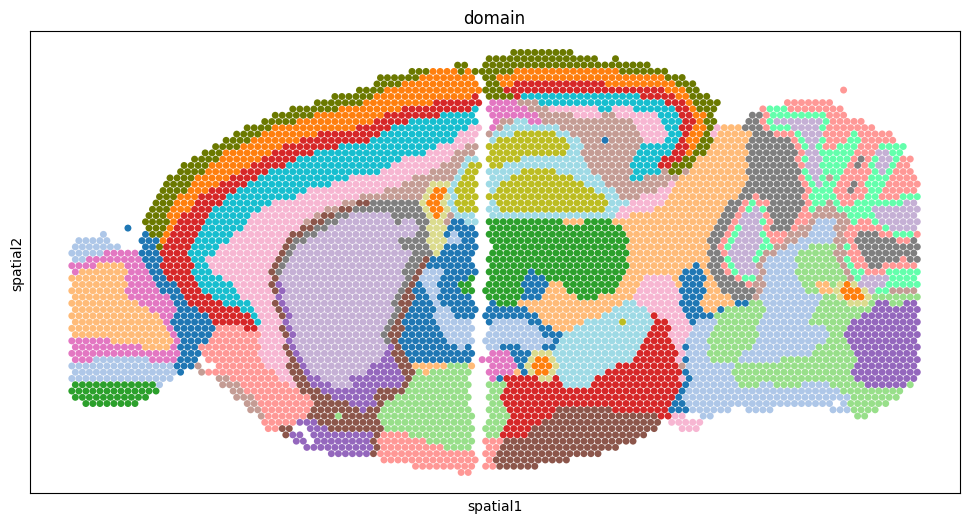

In [9]:
pca = PCA(n_components=20, random_state=42)
embedding = pca.fit_transform(adata.obsm['emb'].copy())
adata.obsm['emb_pca'] = embedding
mclust_R(adata, 36, use_rep='emb_pca', key_added='domain')

rgb_values = sns.color_palette("tab20", len(adata.obs['domain'].unique()))
color_fine = dict(zip(list(adata.obs['domain'].unique()), rgb_values))
color_fine[1] = '#6B7900'
color_fine[23] = '#63FFAC'
plt.rcParams["figure.figsize"] = (12, 6)
sc.pl.embedding(adata, basis="spatial",
                color="domain",
                s=100,
                palette=color_fine,
                show=False, )
plt.gca().legend().set_visible(False)
